<a href="https://colab.research.google.com/github/iamfaith/DeepLearning/blob/master/%E9%AA%8C%E8%AF%81%E7%A0%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# https://drive.google.com/open?id=1EB6rX8ZhIxQHH9gxB2XSkN5NpycaxwYD
!gdown --id '1EB6rX8ZhIxQHH9gxB2XSkN5NpycaxwYD'

Downloading...
From: https://drive.google.com/uc?id=1EB6rX8ZhIxQHH9gxB2XSkN5NpycaxwYD
To: /content/new_label.zip
40.4MB [00:00, 65.7MB/s]


In [0]:
!unzip new_label.zip

Archive:  new_label.zip
   creating: label/
  inflating: label/a6q2.png          
  inflating: label/gg62.png          
  inflating: label/ngbg.png          
  inflating: label/Ac07.png          
  inflating: label/OZIY.png          
  inflating: label/vud9.png          
  inflating: label/7u30.png          
  inflating: label/k4v5.png          
  inflating: label/fdba.png          
  inflating: label/o1tk.png          
  inflating: label/5otz.png          
  inflating: label/K8OL.png          
  inflating: label/7IXM.png          
  inflating: label/2vt0.png          
  inflating: label/gp8u.png          
  inflating: label/68kk.png          
  inflating: label/LDQ7.png          
  inflating: label/16db.png          
  inflating: label/r02l.png          
  inflating: label/O40z.png          
  inflating: label/v9pt.png          
  inflating: label/v5ex.png          
  inflating: label/so95.png          
  inflating: label/gr5p.png          
  inflating: label/1c00.png          
  infl

In [0]:
from torch.utils.data import Dataset, IterableDataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import os
import cv2
import glob
import math
import torch, time
from torchvision.models.resnet import ResNet, BasicBlock
import torch.nn as nn

In [0]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),  # 隨機將圖片水平翻轉
    transforms.RandomRotation(15),  # 隨機旋轉圖片
    # 將圖片轉成 Tensor，並把數值 normalize 到 [0,1] (data normalization)
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])


class IterableDataset(IterableDataset):

    def __init__(self, filepath, transform=None, decoder=None, width=120, height=50, has_label=True):
        # super().__init__()
        self.filepath = filepath
        # img_size = (50, 120)
        self.width, self.height = width, height
        self.transform = transform
        self.decoder = decoder
        self.has_label = has_label
    # def parseFile(self, filepath):
    #     with open(filepath, 'r') as f:
    #         for line in f:

    #             token = line.strip('\n').strip(' ')
    #             print('-----', line, token)
    #             yield from token

    # def get_stream(self, filepath):
        # from itertools import cycle
        # return self.parseFile(filepath)

    def read_img(self, img_dir):
        # print(img_dir)
        for img in img_dir:

            img_gray = Image.open(img).convert('L')
            img_two = img_gray.point(lambda x: 0 if x > 129 else 255)

            x = cv2.resize(
                np.array(img_two), (self.width, self.height))

            # x = cv2.resize(cv2.imread(img), (self.width, self.height))
            # x = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)

            if self.transform is not None:
                x = self.transform(x)



            pos, temp = [], []
            tmp = x.T  # .squeeze(0).numpy()
            for i, col in enumerate(tmp):
                if np.sum(col) > 0:
                    # print(i)
                    if len(pos) == 0:
                        pos.append(i)
                        temp.append(i)
                    else:
                        if temp[len(temp) - 1] + 1 != i:
                            pos.append(i)
                        temp.append(i)
            
            # print('-----', img, pos, len(y), x.shape)

            if len(pos) == 4:
                if self.has_label:
                    y = [self.decoder(i) if self.decoder is not None else i for i in img[-8:-4].lower()]
                for i, p in enumerate(pos):
                    if i < 3:
                        end = pos[i+ 1] - 1
                        if i == 0:
                            start = 0
                        else:
                            start = pos[i] - 1
                    else:
                        start, end = pos[i] - 1, self.width - 1
                    
                    # start, end = pos[i * 2], pos[i * 2 + 1]
                    # print(i, start, end)
                    if self.has_label:
                        charater =cv2.resize(x[:, start:end], (50, 50))
                        yield torch.FloatTensor([charater]), keys.get(y[i])
                    else:
                        charater =cv2.resize(x[:, start:end ], (50, 50))
                        yield torch.FloatTensor([charater])
            else:
                
                os.rename(img, '/content/unreg2/' + os.path.basename(img))
                # print(img)
            # yield x, y

    def __iter__(self):
        return self.read_img(self.filepath)

In [0]:
def train_val_split(path, batch_size=64, decoder=None):
    samples = glob.glob(path)
    np.random.shuffle(samples)
    nb_train = math.ceil(0.9 * len(samples))  # 共有10万+样本，9万用于训练，1万+用于验证
    train_samples = samples[:nb_train]
    train_dataset = IterableDataset(
        train_samples, transform=None, decoder=decoder)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)

    val_samples = samples[nb_train:]

    val_dataset = IterableDataset(val_samples, transform=None, decoder=decoder)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    return train_loader, val_loader, train_samples, val_samples

In [0]:
train_loader, val_loader, train_samples, val_samples = train_val_split(r'/content/label/*png', batch_size=64)

# for i, data in enumerate(train_loader):
#     print(i, data[0].size())
#     break

In [0]:
letter_list = [chr(i) for i in range(97,123)]
char_list =  [str(i) for i in range(0, 10)] + letter_list

keys = {}
values = {}
for i, c in enumerate(char_list):
    keys[c] = i
    values[i] = c

print(keys, len(keys))

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17, 'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25, 'q': 26, 'r': 27, 's': 28, 't': 29, 'u': 30, 'v': 31, 'w': 32, 'x': 33, 'y': 34, 'z': 35} 36


In [0]:
class MnistResNet(ResNet):
    def __init__(self, num_classes=36):
        super(MnistResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
        self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
    def forward(self, x):
        return torch.softmax(super(MnistResNet, self).forward(x), dim=-1)


In [0]:
model = MnistResNet(36).cuda()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epoch = 5

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, data in enumerate(train_loader):
        # print(data[0].size(), data[1])  #, data[1].numpy())
        optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
        train_pred = model(data[0].cuda()) # 利用 model 得到預測的機率分佈 這邊實際上就是去呼叫 model 的 forward 函數


        batch_loss = loss(train_pred, data[1].cuda()) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新參數值
        
        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()
        
        # print(np.argmax(train_pred.cpu().data.numpy(), axis=1))
        

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            val_pred = model(data[0].cuda())
            batch_loss = loss(val_pred, data[1].cuda())

            val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            val_loss += batch_loss.item()

        #將結果 print 出來
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, num_epoch, time.time()-epoch_start_time, \
            train_acc/(len(train_samples) * 4), train_loss/(len(train_samples) * 4), val_acc/(len(val_samples) * 4), val_loss/(len(val_samples) * 4)))

[001/005] 12.25 sec(s) Train Acc: 0.797281 Loss: 0.045030 | Val Acc: 0.899525 loss: 0.043259
[002/005] 12.34 sec(s) Train Acc: 0.941053 Loss: 0.042275 | Val Acc: 0.936709 loss: 0.042630
[003/005] 12.31 sec(s) Train Acc: 0.940789 Loss: 0.042238 | Val Acc: 0.937500 loss: 0.042616
[004/005] 12.33 sec(s) Train Acc: 0.941404 Loss: 0.042224 | Val Acc: 0.935918 loss: 0.042642
[005/005] 12.29 sec(s) Train Acc: 0.950263 Loss: 0.042084 | Val Acc: 0.946203 loss: 0.042479


In [0]:
!gdown --id '1YHUe0Eq8W9qLdnQWVqe4f5JeLSkV2lLh'


Downloading...
From: https://drive.google.com/uc?id=1YHUe0Eq8W9qLdnQWVqe4f5JeLSkV2lLh
To: /content/jpegs.zip
100% 228k/228k [00:00<00:00, 85.3MB/s]


In [0]:
!unzip jpegs.zip

Archive:  jpegs.zip
replace jpegs/63.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
  inflating: jpegs/88.jpg            
  inflating: jpegs/89.jpg            
  inflating: jpegs/74.jpg            
  inflating: jpegs/49.jpg            
  inflating: jpegs/75.jpg            
  inflating: jpegs/59.jpg            
  inflating: jpegs/65.jpg            
  inflating: jpegs/8.jpg             
  inflating: jpegs/99.jpg            
  inflating: jpegs/73.jpg            
  inflating: jpegs/100.jpg           
  inflating: jpegs/29.jpg            
  inflating: jpegs/17.jpg            
  inflating: jpegs/16.jpg            
  inflating: jpegs/38.jpg            
  inflating: jpegs/21.jpg            
  inflating: jpegs/35.jpg            
  inflating: jpegs/20.jpg            
  inflating: jpegs/22.jpg            
  inflating: jpegs/27.jpg            
  inflating: jpegs/32.jpg            
  inflating: jpegs/18.jpg            
  inflating: jpegs/56.jpg            
  inflating: jpegs/94.jpg            
  infl

/content/jpegs/12.jpg


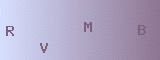

69


In [0]:
test_samples = glob.glob('/content/jpegs/*.jpg')
from google.colab.patches import cv2_imshow
for test in test_samples:
  print(test)
  cv2_imshow(cv2.imread(test))


  break

print(len(test_samples))

['/content/jpegs/12.jpg', '/content/jpegs/79.jpg', '/content/jpegs/82.jpg', '/content/jpegs/7.jpg', '/content/jpegs/81.jpg', '/content/jpegs/67.jpg', '/content/jpegs/61.jpg', '/content/jpegs/37.jpg', '/content/jpegs/11.jpg', '/content/jpegs/96.jpg']


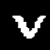

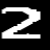

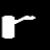

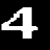

['v', '2', 'r', '4']


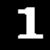

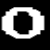

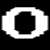

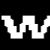

['1', '0', '0', 'w']


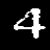

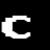

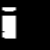

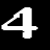

['4', 'c', 'i', '4']


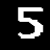

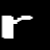

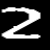

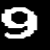

['5', 'r', '2', '9']


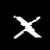

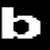

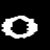

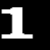

['x', 'b', 'o', '1']


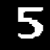

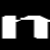

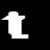

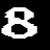

['5', 'm', 't', '8']


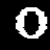

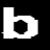

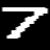

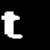

['0', 'b', '7', 't']


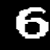

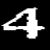

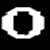

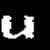

['6', '4', '0', 'u']


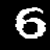

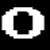

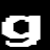

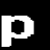

['6', '0', 'g', 'p']


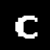

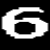

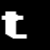

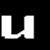

['c', '6', 't', 'u']


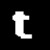

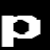

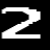

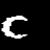

['t', 'p', '2', 'c']


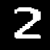

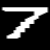

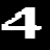

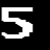

['2', '7', '4', '5']


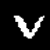

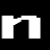

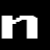

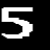

['v', 'n', 'n', '5']


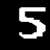

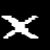

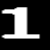

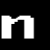

['5', 'x', '1', 'n']


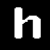

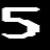

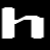

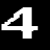

['h', '5', 'h', '4']


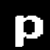

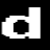

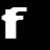

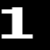

['p', 'd', 'f', '1']


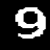

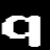

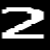

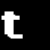

['9', 'q', '2', 't']


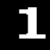

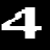

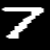

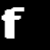

['1', '4', '7', 'f']


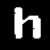

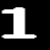

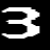

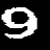

['h', '1', '3', '9']


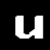

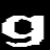

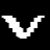

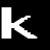

['u', 'g', 'v', 'k']


In [0]:
test_dataset = IterableDataset(val_samples[:20], has_label=False)
# test_dataset = IterableDataset(test_samples[:10], has_label=False)
test_loader = DataLoader(test_dataset, batch_size=4)

model.eval()
print(test_samples[:10])
with torch.no_grad():
    for i, data in enumerate(test_loader):
        prediction = []
        # print(i, data.size()[0])
        for i in range(data.size()[0]):
          cv2_imshow(data[i].numpy().transpose(1,2,0))
        test_pred = model(data.cuda())
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        for y in test_label:
            prediction.append(y)
        
        print([ values.get(p)   for p in prediction] )


In [0]:
from matplotlib import pyplot as plt
%matplotlib inline
import imutils
import zipfile

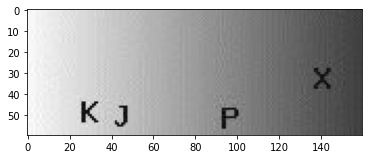

In [0]:
img = cv2.imread('/content/jpegs/79.jpg', 0)
plt.imshow(img, 'gray')

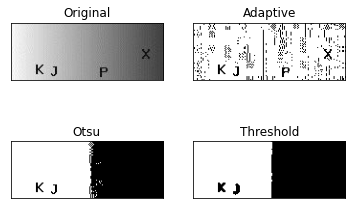

In [0]:
# Adaptive thresholding
th = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 17, 2)

# Otsu thresholding
ret2, th2 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Otsu thresholding with Gaussian Blur
blur = cv2.GaussianBlur(img, (5, 5), 0)
ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#Plot
titles = ['Original', 'Adaptive', 'Otsu', 'Gaussian + Otsu']
images = [img, th, th2, th3]
for i in range(4):
    plt.subplot(2, 2, i + 1), plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])

plt.title('Threshold')
plt.show()

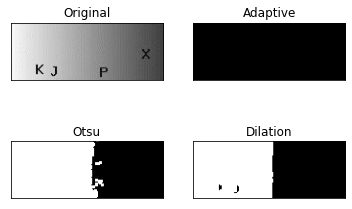

In [0]:
kernel = np.ones((3,3), np.uint8)
dilation = cv2.dilate(th, kernel, iterations=1)
dilation2 = cv2.dilate(th2, kernel, iterations=1)
dilation3 = cv2.dilate(th3, kernel, iterations=1)

titles2 = ['Original', 'Adaptive', "Otsu", 'Gaussian + Otsu']
images2 = [img, dilation, dilation2, dilation3]

for i in range(4):
    plt.subplot(2, 2, i + 1), plt.imshow(images2[i], 'gray')
    plt.title(titles2[i])
    plt.xticks([]), plt.yticks([])
    
plt.title('Dilation')
plt.show()

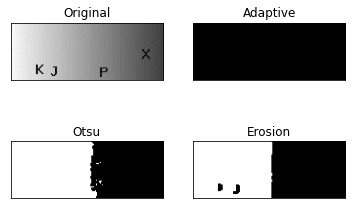

In [0]:
erosion = cv2.erode(dilation, kernel, iterations=1)
erosion2 = cv2.erode(dilation2, kernel, iterations=1)
erosion3 = cv2.erode(dilation3, kernel, iterations=1)

titles3 = ['Original', 'Adaptive', "Otsu", 'Gaussian + Otsu']
images3 = [img, erosion, erosion2, erosion3]

for i in range(4):
    plt.subplot(2, 2, i + 1), plt.imshow(images3[i], 'gray')
    plt.title(titles3[i])
    plt.xticks([]), plt.yticks([])
    
plt.title('Erosion')
plt.show()

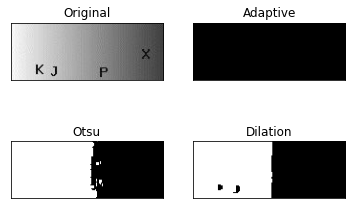

In [0]:
kernel = np.ones((3,1), np.uint8)
dilation = cv2.dilate(erosion, kernel, iterations=1)
dilation2 = cv2.dilate(erosion2, kernel, iterations=1)
dilation3 = cv2.dilate(erosion3, kernel, iterations=1)

titles4 = ['Original', 'Adaptive', "Otsu", 'Gaussian + Otsu']
images4 = [img, dilation, dilation2, dilation3]

for i in range(4):
    plt.subplot(2, 2, i + 1), plt.imshow(images4[i], 'gray')
    plt.title(titles4[i])
    plt.xticks([]), plt.yticks([])

plt.title('Dilation')
plt.show()

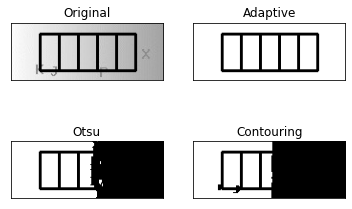

In [0]:
#Get the individual letters.
x, y, w, h = 30, 12, 20, 38
for  i in range(5):
    # get the bounding rect
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.rectangle(dilation, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.rectangle(dilation2, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.rectangle(dilation3, (x, y), (x + w, y + h), (0, 255, 0), 2)
    x += w

titles3 = ['Original', 'Adaptive', "Otsu", 'Gaussian + Otsu']
images3 = [img, dilation, dilation2, dilation3] #img, opening, opening2, opening3]

for i in range(4):
    plt.subplot(2, 2, i + 1), plt.imshow(images3[i], 'gray')
    plt.title(titles3[i])
    plt.xticks([]), plt.yticks([])

plt.title('Contouring')
plt.show()